In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

/opt/anaconda3/envs/MLstudy/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### 데이터 클렌징 및 가공

In [2]:
bike_df = pd.read_csv('./bike-sharing-demand/train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


#### 데이터 피처 확인
* datetime : hourly date + timestamp
* season : 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
* holiday : 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌날
* workingday : 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일
* weather : 
    * 1 = 맑음, 약간 구름 낀 흐림
    * 2 = 안개, 안개 + 흐림
    * 3 = 가벼운 눈, 가벼운 비 + 천둥
    * 4 = 심한 눈/비, 천둥/번개
* temp : 온도(섭씨)
* atemp : 체감온도(섭씨)
* humidity : 상대습도
* windspeed : 풍속
* casual : 사전에 등록되지 않는 사용자가 대여한 횟수
* registered : 사전에 등록된 사용자가 대여한 횟수
* **count : 대여 횟수(target)**

In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


* 대부분 컬럼이 int 또는 float형의 숫자형, datetime 컬럼만 object형
* Datetime 컬럼의 경우 년-월-일 시:분:초 문자 형식으로 돼 있으므로 이에 대한 가공이 필요
* Datetime을 년, 월, 일, 시간과 같이 4개의 속성으로 분리

In [4]:
# 문자열을 datetime 타입으로 변경. 
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


* 새롭게 year, month, day, hour 컬럼이 추가 되었으므로 datetime컬럼 제거
* casual + registered = count이므로 casual + registered 컬럼 제거

In [5]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

#### 예측 성능 측정 함수 구현

In [6]:
# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

### 로그 변환, 피처 인코딩, 모델 학습/예측/평가 

In [7]:
y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False)

* 회귀에서 데이터중 가장 먼저 살펴볼 것은 Target 값의 분포가 왜곡된 형태를 이루고 있는지 확인하는 것이다.
* Target 값의 분포가 외곡 되어있다면 예측에서 큰 오류가 발생할 가능성이 있다.
* Target 값은 정규 분포 형태가 가장 좋다.
* count 컬럼의 값이 0~200 사이에 왜곡돼어 있는것을 확인할 수 있다.
* 로그 변환을 통해 Target 값을 정규화 하는 작업이 필요

<AxesSubplot:>

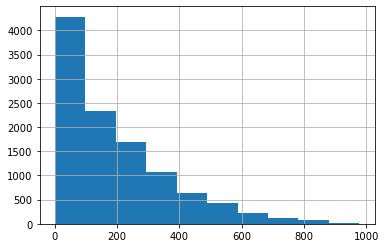

In [8]:
y_target.hist()

<AxesSubplot:>

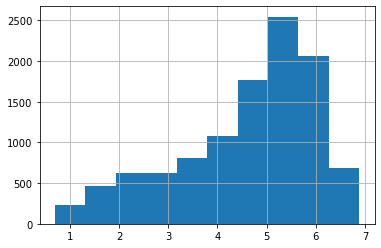

In [9]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

* target 컬럼인 count log 변환 수행
* 카테고리형 변수 원핫 인코딩 변환
    * year 피처와 같이 2011, 2012와 같은 숫자형 카테고리 값을 회귀에 사용할 경우 회귀 계수를 연산할 때 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있다.
    * 따라서 회귀에서는 이러한 피처 인코딩에 원-핫 인코딩을 적용해 변환해야함

In [10]:
# 타겟 컬럼인 count 값을 log1p 로 Log 변환
y_target_log = np.log1p(y_target)
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

#### 기본적인 Tree기반 앙상블 모델로 모델 학습 및 평가 수행

In [11]:
# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
    
# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.128, MAE: 31.072
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.365, MAE: 32.752
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


#### 가장 성능이 좋은 LightGBM기반 모델을 하이퍼 파라미터 튜닝
* num_leaves
    * 하나의 트리가 가질수 있는 최대 leaf node 개수
* max_depth
    * 트리의 최대 깊이
* min_child_samples
    * 리프 노드가 되기 위한 최소한의 샘플 수, 클수록 분할을 자제하며 과적합을 조절하기 위해 사용
* subsample
    * 과적합을 제어하기 위해 데이터를 샘플링하는 비율

In [12]:
def print_best_params(model, params):
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        cv=5,
        scoring='neg_mean_squared_error')

    grid_model.fit(X_train, y_train)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값 {1}, 최적 alpha:{2}'.format(model.__class__.__name__, 
                                                             np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [13]:
params = {'num_leaves': [16, 32, 64],
          'max_depth':[64, 128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 0.9, 1]}

lgbm_reg = LGBMRegressor(n_estimators=500)
lgb_estimator = print_best_params(lgbm_reg, params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값 0.3143, 최적 alpha:{'max_depth': 64, 'min_child_samples': 60, 'num_leaves': 32, 'subsample': 0.8}


In [14]:
lgbm_reg = LGBMRegressor(n_estimators=500, max_depth=64, min_child_samples=60, num_leaves=32, subsample=0.8)
get_model_predict(lgbm_reg, X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### LGBMRegressor ###
RMSLE: 0.323, RMSE: 46.995, MAE: 29.016
